#### The Objective of this exercise is to infer gender based on the set of information shared around customers buying habits. Clustering of some sort will be performed to identify segments of data that are homogenous using which we will interpret the clusters to infer gender. 

##### This notebook follows the following steps

1. Data Preprocessing
2. Data processing to create new features
3. Clustering approach
4. Results analysis and synthesis

In [1]:
#Load the required packages for data processing
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette() 
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore")
%precision 4

from datetime import datetime
from datetime import date

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from datetime import datetime
from datetime import date

from dateutil.relativedelta import relativedelta
from datetime import timedelta

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
df=pd.read_json('/Users/srirathivarman/Downloads/data.json',orient='columns')

In [345]:
df.shape

(46279, 43)

In [6]:
#See if the imported data types as per the definitions mentioned github page (seems like)
df.dtypes

afterpay_payments             int64
android_orders                int64
apple_payments                int64
average_discount_onoffer    float64
average_discount_used       float64
cancels                       int64
cc_payments                   int64
coupon_discount_applied     float64
curvy_items                   int64
customer_id                  object
days_since_first_order        int64
days_since_last_order         int64
desktop_orders                int64
devices                       int64
different_addresses           int64
female_items                  int64
home_orders                   int64
ios_orders                    int64
is_newsletter_subscriber     object
items                         int64
macc_items                    int64
male_items                    int64
mapp_items                    int64
mftw_items                    int64
msite_orders                  int64
mspt_items                    int64
orders                        int64
other_collection_orders     

#### Data Pre-Processing

1. The dataset seem to contain duplicate rows. On closer inspection there are 249 customers with identical duplicate rows. Duplicates need ot be removes. 

2. Only one column seem to contain null value rest all are consitent. Lets impute nulls appropriately. 

In [9]:
#Lets see the unique number of customers
print (len(df['customer_id'].unique()))

#Dropping Duplicates customer rows
df_1=df.drop_duplicates(subset=['customer_id'], keep='first').reset_index()
df_1.drop(columns=['index'], axis=1, inplace=True)

In [10]:
df_1.shape

(46030, 43)

In [12]:
#Lets check for nulls and other data inconsistencies
df_1.isnull().sum()

afterpay_payments               0
android_orders                  0
apple_payments                  0
average_discount_onoffer        0
average_discount_used           0
cancels                         0
cc_payments                     0
coupon_discount_applied     10204
curvy_items                     0
customer_id                     0
days_since_first_order          0
days_since_last_order           0
desktop_orders                  0
devices                         0
different_addresses             0
female_items                    0
home_orders                     0
ios_orders                      0
is_newsletter_subscriber        0
items                           0
macc_items                      0
male_items                      0
mapp_items                      0
mftw_items                      0
msite_orders                    0
mspt_items                      0
orders                          0
other_collection_orders         0
other_device_orders             0
parcelpoint_or

In [14]:
#Impute strategy to fill nulls with zero to indicate no coupon discount was applied
df_1['coupon_discount_applied']=df_1['coupon_discount_applied'].fillna(value=0)

We have pre-processed the data by removing duplicates and taking care of nulls. Lets closely inspect different categories of customer attributes around the following dimensions and create new behavioral featuers

#### 1. Time Dimension 
       --> 'Days since first order', 'Days since last order'
#### 2. Payments Dimension 
       --> 'cc payments', 'apple payments, 'after pay payments', 'paypal payments'
#### 3. Orders, Desitnation Dimensions and Shipping Address
       --> 'home orders', 'work orders', 'parcelpoint_orders', 'other_collection_orders'
       --> 'different addresses' 'shipping address'
       --> 'Orders', 'Cancels', 'Returns'
#### 4. Item Dimension 
       --> 'items', 'male items', 'female items', 'unisex items', 'curvy items', 'sacc items'
       --> 'macc items', 'mapp items', 'mftw items', 'mspt items'
       --> 'wacc items', 'wapp items', 'wftw items', 'wspt items'
#### 5. Device Dimension
       --> 'ios orders', 'andriod orders', 'desktop_orders', 'msite_orders', 'other_device_orders','devices'
#### 6. Discount Dimension
       --> 'average_discount_onoffer', 'average_discount_used', 'coupon_discount_applied', 'redpen_discount_used'
       --> 'Vouchers', 'revenue'


### 1. Time Dimension

-> On observing days_since_first_order through a distribution plot, we can observe that is skewed towards left indicating a lot of customers made their first purchase around 3 to 4 years back. 

--> On observing days_since_last_order it is bimodal (indicating a lot of users purchased once and never purchased later)
         
         1) their values are greater than days_since_first_order (not possible!!)
         
         2) Translating to year from days some rows indicate last purchase falls as far back as 100 years. However,   
            Iconic was formed in 2011 this is an unlikely scenario. On closer observation we can find that the 
            values are hours as supposed to days. Lets scale that by 24 to obtain values in days. 
            
_**Feature Creation:**_

1. Instead of using the values as is, it would be easier to understand the days_since_first_order and its impact if binned into levels like early joiner, mid joiner and recent joiner (**tenure_flag**). __A distribution based binning would be better compared to arbitraty binning.__ 

2. Similarly days_since_last_order could be binned into levels like active, midly active and inactive (**active_flag**)

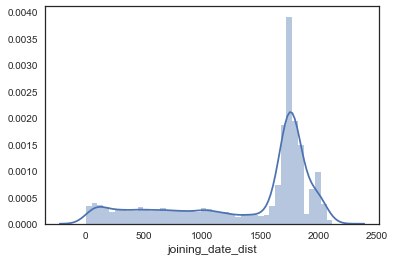

In [488]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['days_since_first_order'].values,kde=True)
plt.xlabel('joining_date_dist', fontsize=12)
plt.show()

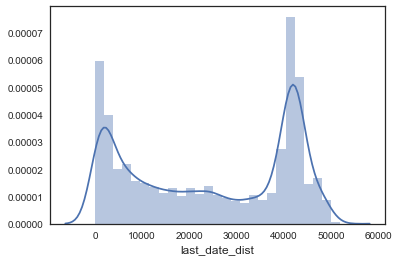

In [489]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['days_since_last_order'].values,kde=True)
plt.xlabel('last_date_dist', fontsize=12)
plt.show()

In [19]:
#Days since last order is probably reflecting hours since last order need to rescale by 24 hours to obtain date. 
df_1['days_since_last_order_correct']=df_1['days_since_last_order']/24

In [20]:
c1=pd.cut(df_1['days_since_first_order'],3,retbins=True,precision=3,include_lowest=True)
print (c1[1])
print (c1[0].value_counts())

[-1.163e+00  7.220e+02  1.443e+03  2.164e+03]
(1443.0, 2164.0]    29312
(-1.164, 722.0]      9501
(722.0, 1443.0]      7217
Name: days_since_first_order, dtype: int64


In [21]:
c1=pd.cut(df_1['days_since_last_order_correct'],3,retbins=True,precision=3,include_lowest=True)
print (c1[1])
print (c1[0].value_counts())

[-1.1590e+00  7.2067e+02  1.4403e+03  2.1600e+03]
(1440.333, 2160.0]     19169
(-1.16, 720.667]       18515
(720.667, 1440.333]     8346
Name: days_since_last_order_correct, dtype: int64


In [22]:
#create tenure flag
bins=[0,722, 1443, 2164]
labels=['recent','mid','early']
df_1['tenure_flag']=pd.cut(df_1['days_since_first_order'],bins=bins,include_lowest=True,labels=labels)

In [23]:
#create active flag
bins=[0,720, 1440, 2160]
labels=['active','mildy_active','inactive']
df_1['active_flag']=pd.cut(df_1['days_since_last_order_correct'],bins=bins,include_lowest=True,labels=labels)

### 2. Payments Dimension

All the payments dimensions are either 1 or 0 indicating if a specific type of payment method was used by the customer. Along with these we can create total number of different payments options used by a customer

_**Feature Creation:**_

1. Number of different payment options used would be a better behavioural attribute (**no_of_payment**)

In [351]:
df_1['no_of_payment']=df_1['cc_payments']+df_1['apple_payments']+df_1['afterpay_payments']+df_1['paypal_payments']

In [352]:
df_1['no_of_payment'].value_counts()

1    37769
2     7471
3      650
0      140
Name: no_of_payment, dtype: int64

### 3. Orders, Desitnation Dimensions and Shipping Address

#### Order Destination Dimension

The distribution of work_orders, home_orders, parcel points orders and other collections are extremly skewed. Using these variables as is wouldn't yeild any behavioral patterns as supposed to understanding those variable as percentage of overall orders for that customer. 

_**Feature Creation:**_

1. **work_orders_ratio** --> Percentage of work orders to overall orders
2. **home_orders_ratio** --> Percentage of home orders to overall orders
3. **parcelpoint_orders_ratio** --> Percentage of parcel point orders to overall orders
4. **other_collection_orders_ratio** --> Percentage of other collection orders to overall orders


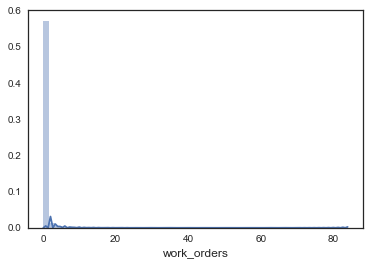

In [492]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['work_orders'].values,kde=True)
plt.xlabel('work_orders', fontsize=12)
plt.show()

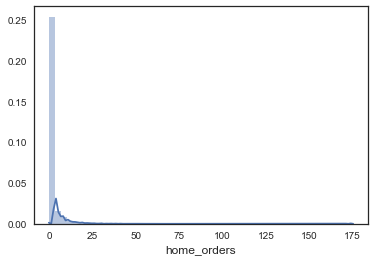

In [490]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['home_orders'].values,kde=True)
plt.xlabel('home_orders', fontsize=12)
plt.show()

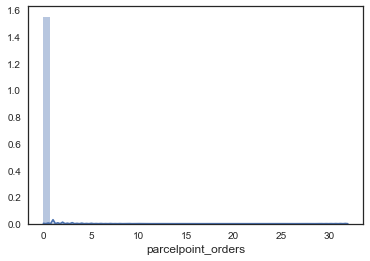

In [493]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['parcelpoint_orders'].values,kde=True)
plt.xlabel('parcelpoint_orders', fontsize=12)
plt.show()

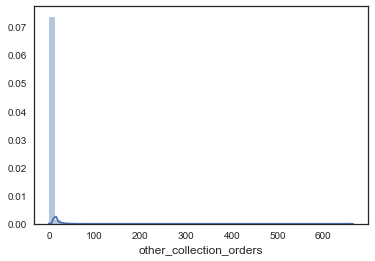

In [494]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['other_collection_orders'].values,kde=True)
plt.xlabel('other_collection_orders', fontsize=12)
plt.show()

In [35]:
#Ratio of work orders, home orders, parcelpoint, other collections
df_1['work_orders_ratio']=df_1['work_orders']/df_1['orders']
df_1['home_orders_ratio']=df_1['home_orders']/df_1['orders']
df_1['parcelpoint_orders_ratio']=df_1['parcelpoint_orders']/df_1['orders']
df_1['other_collection_orders_ratio']=df_1['other_collection_orders']/df_1['orders']

#### Shipping address 

We observe that ~89% of customers have used utmost 2 shipping address. It would be prudent to bin it into customers with one shipping address, customers with two shipping address and customers with more than 2 shipping address

_**Feature Creation:**_

1. **Shipping_address_bin** --> 3 levels (one, two & more than two)

In [31]:
df_1['shipping_addresses'].value_counts()

1     33509
2      7332
3      2664
4      1222
5       595
6       338
7       180
8        72
9        48
10       36
11       13
12       11
13        6
14        3
15        1
Name: shipping_addresses, dtype: int64

In [32]:
#Binning Shipping address
df_1['shipping_address_bin']=['one' if x==1 else 'two' if x==2 else 'more_than_two' for x in df_1['shipping_addresses']]

#### Orders 

Items distribution are extremely skewed. Cancels and returns is very sparse. Similar to logic employed order destination variable we will derive new variables that exhibit customer behavior

_**Feature Creation:**_

1. **items_per_order** --> Useful behaviour to understand what is the batch size of each customer
2. **cancel_ratio** --> Percentage of orders that are cancels on an average
3. **returns_ratio** --> Percentage of orders that are returned on an average

In [29]:
#Items per order
df_1['items_per_order']=df_1['items']/df_1['orders']

#Cancel percentage
df_1['cancel_ratio']=df_1['cancels']/df_1['orders']

#Returns items percentage (assumption is items are returned as supposed to orders)
df_1['returns_ratio']=df_1['returns']/df_1['items']

### 4. Items Dimension

The various of types of items categories rolls up (few inconsitencies were noted were roll ups weren't in order) to male_items, female_items and unisex_items, which rolls up to items overall. 

Since we are focused on geneder inference, it would be better to focus on higher level aggregates. The Distribution of each high level aggregate is skewed and sparse. Also, instead of using the variables as-is, a better behavior would be using percentage of it to overall items purchased. 

_**Feature Creation:**_

1. **male_items_ratio** --> Percentage of male items to overall items
2. **female_items_ratio** --> Percentage of female items to overall items
3. **unisex_items_ratio** --> Percentage of unisex items to overall items

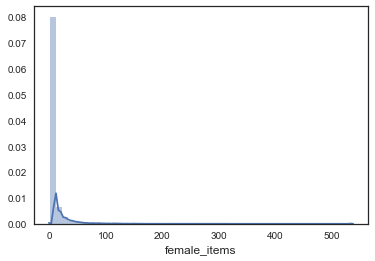

In [487]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['female_items'].values,kde=True)
plt.xlabel('female_items', fontsize=12)
plt.show()

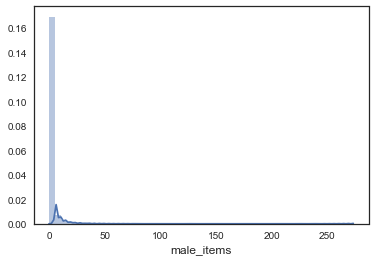

In [486]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['male_items'].values,kde=True)
plt.xlabel('male_items', fontsize=12)
plt.show()

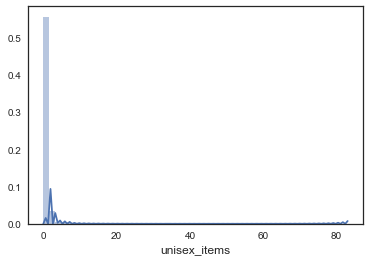

In [485]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['unisex_items'].values,kde=True)
plt.xlabel('unisex_items', fontsize=12)
plt.show()

In [28]:
#Ratio of Male items, female items, unisex items
df_1['male_items_ratio']=df_1['male_items']/df_1['items']
df_1['female_items_ratio']=df_1['female_items']/df_1['items']
df_1['unisex_items_ratio']=df_1['unisex_items']/df_1['items']

### 5. Device Dimension

Around 65% of the are from desktop platform and the rest of from mobile site, ios and android orders. The distributions are skewed and sparse for msite, ios and andriod orders. Combining msite, ios and andriod into smartphone orders would be better. Also, instead of using the variables as-is, a better behavior would be using percentage of it to overall orders.

_**Feature Creation:**_

1. **desktop_ratio** --> Percentage of desktop order to overall orders
2. **smartphone_orders_ratio** --> Percentage of smartphone orders to overall oders

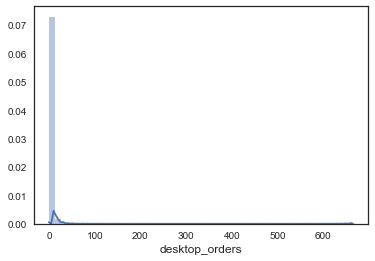

In [495]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['desktop_orders'].values,kde=True)
plt.xlabel('desktop_orders', fontsize=12)
plt.show()

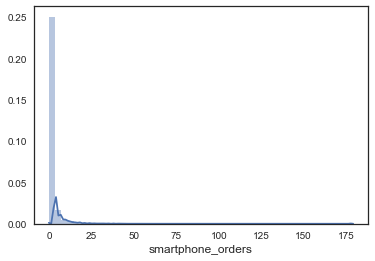

In [496]:
plt.figure(figsize=(6,4))
sns.distplot((df_1['android_orders']+df_1['ios_orders']+df_1['msite_orders']).values,kde=True)
plt.xlabel('smartphone_orders', fontsize=12)
plt.show()

In [30]:
#Smartphone orders ratio
df_1['smartphone_orders_ratio']=(df_1['android_orders']+df_1['ios_orders']+df_1['msite_orders'])/df_1['orders']

#Desktop orders ratio
df_1['desktop_ratio']=df_1['desktop_orders']/df_1['orders']

### 6. Discounts Dimension

1. Around 29.5k (~65%) customers average_discount_used is the same as average_discount_on_offer is scaled down by a factor 10000. By definition average_discount_used is average discount finally used on top of average_discount_on_offer, which indicates average_discount_used is sum of average_discount_on_offer and discount used on top of it. By subtracting average_discount_on_offer from average_discount_used, actually average_discous_used could be obtained. 

2. By vouchers distribution is long tailed and skewed. Hence a better behavior attribute would be vouchers used per order 

_**Feature Creation:**_

1. **average_discount_used_new_correct** 
2. **vouchers_per_order** --> Useful behaviour to understand average vouchers used per order

In [27]:
#Average discount used seem to scaled by 10000 and also added to average discount on offer 
#~29.5k customers of descaled average discount used is the same as average discount on offer ~64%

df_1['average_discount_used_new']=df_1['average_discount_used']/10000
df_1['average_discount_used_new']=df_1['average_discount_used_new'].round(4)
df_1['average_discount_onoffer']=df_1['average_discount_onoffer'].round(4)

In [26]:
df_1['flag']=[1 if x[0]==x[1] else 0 for x in df_1[['average_discount_used_new','average_discount_onoffer']].values]
df_1['average_discount_used_new_correct']=[0 if x[0]==1 else (x[1]-x[2]) for x in df_1[['flag','average_discount_used_new','average_discount_onoffer']].values]

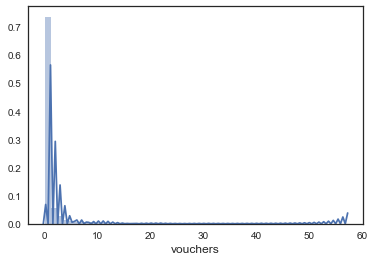

In [497]:
plt.figure(figsize=(6,4))
sns.distplot(df_1['vouchers'].values,kde=True)
plt.xlabel('vouchers', fontsize=12)
plt.show()

In [41]:
#Vouchers_per_order
df_1['vouchers_per_order']=df_1['vouchers']/df_1['orders']

### Clustering

The following clustering approach is used

1. Neighbourhood Embedding using **Self Organizing Maps** (SOM). SOM is a useful neural network technique (*robust to categorical and continous variable*) to identify neighbhourhoods of similar customers in a 2-D representation also good for dimensionality reduction

2. **Gaussian mixture models** (GMM) with neighbourhood embedding as the input. GMMs are distribution based clustering approach which does soft assignment based on expectation maximization instead

3. **silhouette Coefficient** with **mahalanobis distance** will be used as the evaluation metric for assessing the clustering performance

In [45]:
#Loading relevent clustering Libraries
#Scikit libraries 
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import mixture

#Data Preprocessing packages
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#Minisom package for SOM
from minisom import MiniSom

#Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import seuclidean

import pickle
import dill as pickle

In [46]:
scalar=StandardScaler()

#### Data Processing

**1. One hot encoding for categorical variables**

**2. Scale normalization for continuous variables**

In [376]:
#define the columns for which one hot  need to be created
cols_to_transform = ['tenure_flag', 'active_flag','shipping_address_bin','is_newsletter_subscriber','devices','no_of_payment']
df_wd = pd.get_dummies(df_1,columns = cols_to_transform)

In [377]:
#Normalize scale for variables
cols_to_scale=['revenue','vouchers','items','orders','male_items','coupon_discount_applied',
               'female_items','unisex_items','cancels','returns','phone_orders','desktop_orders']
df_wd[cols_to_scale]=scalar.fit_transform(df_wd[cols_to_scale])

#### Exploring potential variables to be choseng for clustering

1. Groups of variables exhibiting high degree of correlation among each other would be choses
2. Variables with less or no variation around customer base would be ignored

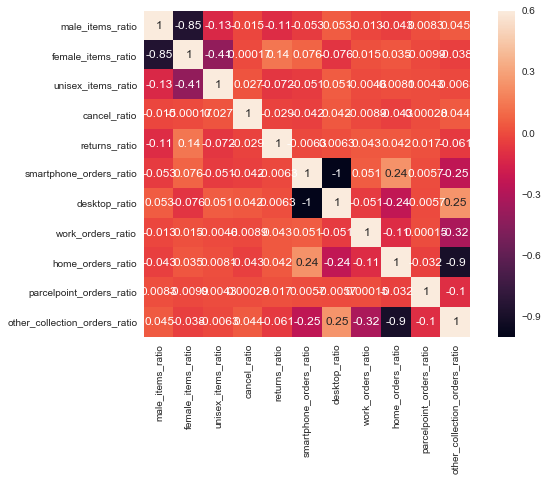

In [498]:
cols=['male_items_ratio','female_items_ratio','unisex_items_ratio','cancel_ratio','returns_ratio',
                     'smartphone_orders_ratio','desktop_ratio','work_orders_ratio','home_orders_ratio',
                     'parcelpoint_orders_ratio','other_collection_orders_ratio']
plt.figure(figsize=(10,6))
corr = df_wd[cols].corr()
sns.heatmap(corr, vmax=0.6, square=True, annot=True)

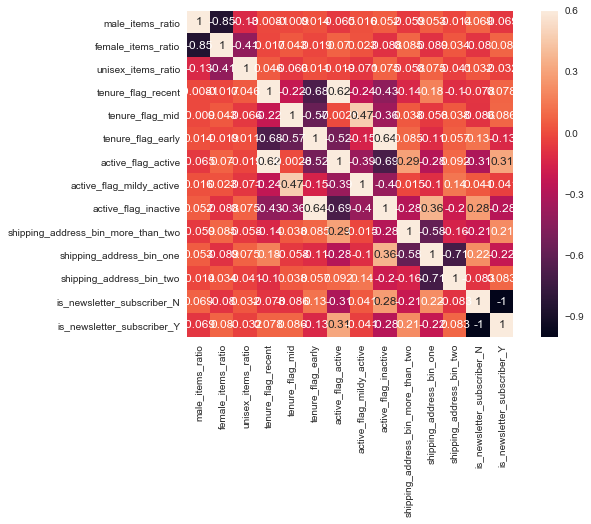

In [499]:
cols=['male_items_ratio','female_items_ratio','unisex_items_ratio','tenure_flag_recent','tenure_flag_mid',
      'tenure_flag_early','active_flag_active','active_flag_mildy_active','active_flag_inactive',
      'shipping_address_bin_more_than_two','shipping_address_bin_one','shipping_address_bin_two',
      'is_newsletter_subscriber_N','is_newsletter_subscriber_Y']
plt.figure(figsize=(10,6))
corr = df_wd[cols].corr()
sns.heatmap(corr, vmax=0.6, square=True, annot=True)

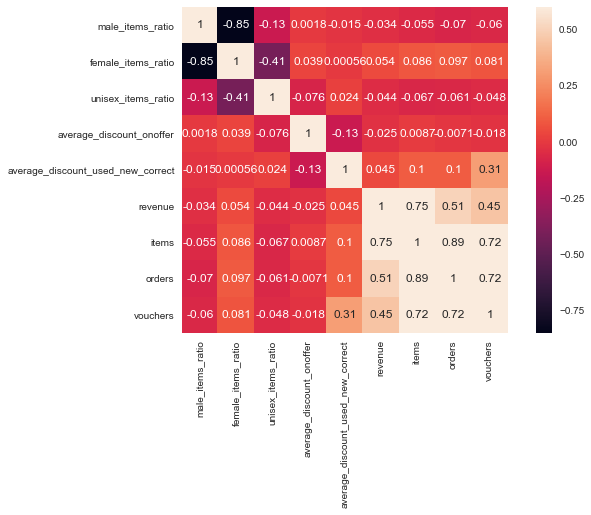

In [500]:
cols=['male_items_ratio','female_items_ratio','unisex_items_ratio','average_discount_onoffer',
                     'average_discount_used_new_correct','revenue','items','orders','vouchers']
plt.figure(figsize=(10,6))
corr = df_wd[cols].corr()
sns.heatmap(corr, vmax=0.6, square=True, annot=True)

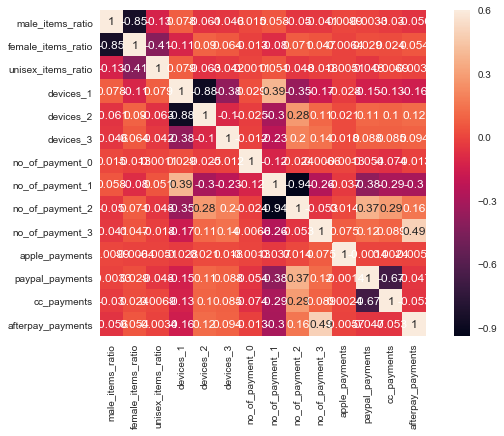

In [503]:
cols=['male_items_ratio','female_items_ratio','unisex_items_ratio','devices_1','devices_2','devices_3',
      'no_of_payment_0','no_of_payment_1','no_of_payment_2','no_of_payment_3','apple_payments','paypal_payments',
     'cc_payments','afterpay_payments']
plt.figure(figsize=(10,6))
corr = df_wd[cols].corr()
sns.heatmap(corr, vmax=0.6, square=True, annot=True)

### Clustering start


1. For **SOM** the following parameters were used 

       --> Grid size        : 5*5, 7*7, 10*10
       --> Sigma            : 1.0, 1.5, 2.5
       --> Learning rate    : 0.1, 0.01
       
2. For **GMM** the following parameters were used

        --> number of components         : 2,3,4
        --> weight_concentration_prior   : 0.33, 0.001
        
#### Models with the best variables and tuning parameters maximizing silhouette score and reasonable definitions is represented below

In [430]:
#Columns selectd for clustering 
cols_for_clustering=['male_items_ratio','female_items_ratio','unisex_items_ratio','home_orders_ratio',
                     'other_collection_orders_ratio',
                     'tenure_flag_recent','tenure_flag_mid','tenure_flag_early','active_flag_active',
                     'active_flag_mildy_active','active_flag_inactive','shipping_address_bin_more_than_two',
                     'shipping_address_bin_one','shipping_address_bin_two','is_newsletter_subscriber_N',
                     'is_newsletter_subscriber_Y','average_discount_onoffer',
                     'average_discount_used_new_correct','revenue','items','orders','vouchers']

In [431]:
df_matrix=df_wd[cols_for_clustering].values

In [159]:
# Initialization and training SOM (SOMs results migh vary depending on initialization)
som = MiniSom(7, 7, len(df_matrix[0,:]), sigma=2.5, learning_rate=0.01)
som.random_weights_init(df_matrix)
print("Training...")
#som.train_batch(df_matrix, 10000) # batch training
som.train_random(df_matrix, 50000)  # random training
print("\n...ready!")

Training...

...ready!


In [160]:
win = []
for i,j in enumerate(df_matrix):
    win.append(som.winner(j))
win_arr=np.array(win)

In [161]:
#Normalize SOM grid numbers
normal=Normalizer()
win_arr_norm=normal.fit_transform(win_arr)

In [162]:
#Train a GMM Model
gmm_model = mixture.BayesianGaussianMixture(n_components=3, covariance_type='full',weight_concentration_prior=0.001).fit(win_arr_norm)

In [408]:
#Get lable assignments from GMM clustering
labels = gmm_model.predict(win_arr_norm)

#Get customer counts per labels
unique, counts = np.unique(labels, return_counts=True)
d=pd.DataFrame([unique, counts]).T
print (d)

   0      1
0  0  20102
1  1  20066
2  2   5862


In [400]:
#Assessing the quality of clustering
print (metrics.silhouette_score(win_arr_norm, labels, metric='mahalanobis',sample_size=46030,random_state=np.random.seed(10)))

0.7251408786454422


In [166]:
#Assign cluster labels to orignial dataset to define clusters
df_1['cluster_label']=labels

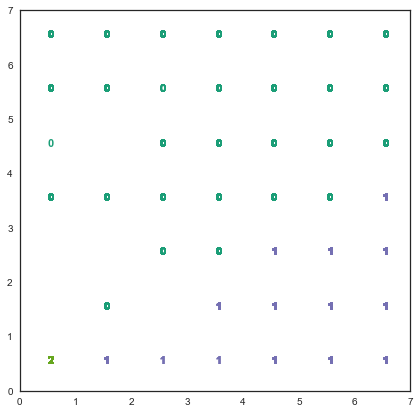

In [508]:
#Graphical representation of Clustering output on the SOM Grid
plt.figure(figsize=(7, 7))
wmap = {}
im = 0
for x, t in zip(df_matrix, labels):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.Dark2(t / 4.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])
plt.show()

In [459]:
#Source : https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
from matplotlib.patches import Ellipse

def draw_structure(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the shape
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm_model(gmm_model, df, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm_model.predict(df)
    if label:
        ax.scatter(df[:, 0], df[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(df[:, 0], df[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm_model.weights_.max()
    for pos, covar, w in zip(gmm_model.means_, gmm_model.covariances_, gmm_model.weights_):
        draw_structure(pos, covar, alpha=w * w_factor)

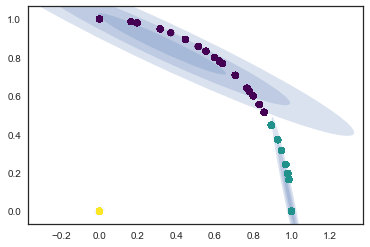

In [460]:
#Visualizing location and shapes of GMM Clusters --> we observe that they are elliptical  
plot_gmm_model(gmm_model,win_arr_norm)

In [295]:
#Persisting models
pickle.dump(som, open('SOM_Model', 'wb'))
pickle.dump(scalar, open('Scalar_Process_of_features', 'wb'))
pickle.dump(normal, open('Normalize_Process_of_features', 'wb'))
pickle.dump(gmm_model, open('GMM_Model', 'wb'))

In [439]:
#Save results to disk
df_1.to_csv("/Users/srirathivarman/Desktop/clusters_with_data.csv",header=True,sep=',',encoding='utf-8')

### Analysis of clustering output to define clusters

* Cluster 2 characterise higher *male items* and *unisex items percentage* (across apparel, accesories, footware & sports wear), lower *returns percentage*, less *vouchers usage* and less *coupon and redpen discount* usage


* Cluster 0 and 1 characterise higher *female itmes percentage* (across categories), higher percentage of *home and work destination orders* compared to cluster 2, higher *coupon and redpen discount usage* and *higher returns ratio* 

So we can infer with a degree of confidence that **Cluster 2** characterises a **Male**, where as **Cluster 0** and **Cluster 1** characterise a **Female** (seems like two different segments exists with in Female)

### Analysis of cluster indexes

Lets create indexes for certain variables of interest and asssess how each cluster performs (are they over indexing or under indexing) against overall customer base

**Index formula = (Average of feature for a cluster/ Average of feature for entire customer base) - 1**

From Indexing results we can observe that 

1. **Cluster 2 Male cluster** is heavily *over indexing* on male_items_ratio and unisex_items_ratio and heavily *under indexing* on female_items_ratio, home & work orders ratio and discounts

2. **Cluster 0 Female Cluster** is heavily *over indexing* on redpen and coupon discounts and heavily *under indexing* on unisex_items_ratio, home & work orders ratio and cancel_ratio

3. **Cluster 1 Female Cluster** is heavily *over indexing* on female_items_ratio, home and work orders and heavily *under indexing* on male_items_ratio, redpen and coupon discounts

### Other Observations

*For Male Cluster* (Cluster 2)

* None of the male cluster customers have new letter subscription
* Male cluster customer are inactive (no recent activity in the past 2 years) post thier first purchase
* They made their first purchase almost 5 years ago 
* Male cluster orders are shipped to other_collection_orders none to home or work :)
* Relatively higher desktop use, (Iconic wasn't available at that time or in its infancy stage)
* Average revenue is twice as less compared to lowest female clusters average
* Average orders per customers is 25% less compared to the lowest female cluster average

For Female Cluster 

* There are two distinctive female segments
    1. Cluster 0 female segment spends far higher than cluster 1
    2. Cluster 0 female segment uses higher average coupon discount and redpendiscount than cluster 1
    3. Cluster 0 female segment has ~3.5 more average orders per customer than cluster 1
    4. Cluster 0 female segment has ~25% more items per order than cluster 1
    5. Cluster 1 female segment has 2.5 times more home orders compared to cluster 0
    6. ~45% of Cluster 1 recent joiners compared to 70% of cluster 0 who had joined much earlier 
    7. ~60% of Cluster 1 are active compared to ~30% of cluster 0 
    8. ~70% of Cluster 1 have subscribed to new letter compared to ~35% of cluster 0

In [473]:
#Lets assess which these parameters for each cluster based on how they are indexing to the overall population
mr_pt=df_1.pivot_table(index=['cluster_label'], values=['male_items_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
fr_pt=df_1.pivot_table(index=['cluster_label'], values=['female_items_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
ur_pt=df_1.pivot_table(index=['cluster_label'], values=['unisex_items_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
wr_pt=df_1.pivot_table(index=['cluster_label'], values=['work_orders_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
hr_pt=df_1.pivot_table(index=['cluster_label'], values=['home_orders_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
or_pt=df_1.pivot_table(index=['cluster_label'], values=['other_collection_orders_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
do_pt=df_1.pivot_table(index=['cluster_label'], values=['average_discount_onoffer'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
du_pt=df_1.pivot_table(index=['cluster_label'], values=['average_discount_used_new_correct'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
cd_pt=df_1.pivot_table(index=['cluster_label'], values=['coupon_discount_applied'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
rd_pt=df_1.pivot_table(index=['cluster_label'], values=['redpen_discount_used'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
io_pt=df_1.pivot_table(index=['cluster_label'], values=['items_per_order'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
vo_pt=df_1.pivot_table(index=['cluster_label'], values=['vouchers_per_order'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
cr_pt=df_1.pivot_table(index=['cluster_label'], values=['cancel_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T
rr_pt=df_1.pivot_table(index=['cluster_label'], values=['returns_ratio'],aggfunc=np.mean,margins=True).reset_index().drop(columns=['cluster_label'],axis=1).T

#Concatenate each pivots
d=pd.concat([mr_pt, fr_pt,ur_pt,wr_pt,hr_pt,or_pt,do_pt,du_pt,cd_pt,rd_pt,io_pt,vo_pt,cr_pt,rr_pt])

In [479]:
#Create index values for each clusters
d['cluster_0_index']=(d[0]/d[3])-1
d['cluster_1_index']=(d[1]/d[3])-1
d['cluster_2_index']=(d[2]/d[3])-1
#Create Index coloring flags
d['c0i_f']=[True if x>=0 else False for x in d['cluster_0_index']]
d['c1i_f']=[True if x>=0 else False for x in d['cluster_1_index']]
d['c2i_f']=[True if x>=0 else False for x in d['cluster_2_index']]

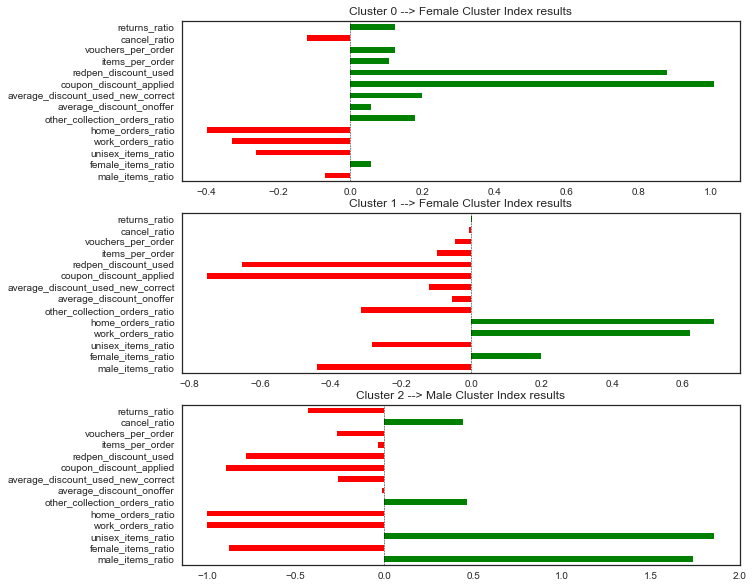

In [546]:
#f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
plt.subplots(figsize=(10,10))
plt.subplot(311)
d['cluster_0_index'].plot(kind='barh', color=d.c0i_f.map({True: 'g', False: 'r'}))
plt.axvline(linestyle='--',color='k',linewidth=0.5)
plt.title('Cluster 0 --> Female Cluster Index results')
plt.subplot(312)
d['cluster_1_index'].plot(kind='barh', color=d.c1i_f.map({True: 'g', False: 'r'}))
plt.axvline(linestyle='--',color='k',linewidth=0.5)
plt.title('Cluster 1 --> Female Cluster Index results')
plt.subplot(313)
d['cluster_2_index'].plot(kind='barh', color=d.c2i_f.map({True: 'g', False: 'r'}))
plt.axvline(linestyle='--',color='k',linewidth=0.5)
plt.title('Cluster 2 --> Male Cluster Index results')
plt.show()

In [414]:
#Analysis of clusters against primary features 
df_cl1=df_1.groupby('cluster_label').agg({'male_items_ratio':'mean','female_items_ratio':'mean',
                                          'unisex_items_ratio':'mean','vouchers':'mean','revenue':'mean',
                                          'average_discount_onoffer':'mean','average_discount_used_new_correct':'mean',
                                          'smartphone_orders_ratio':'mean','desktop_ratio':'mean','cancel_ratio':'mean',
                                          'returns_ratio':'mean','items_per_order':'mean','work_orders_ratio':'mean',
                                          'parcelpoint_orders_ratio':'mean','other_collection_orders_ratio':'mean',
                                          'home_orders_ratio':'mean','no_of_payment':'mean'}).reset_index()
df_cl1.T

,0,1,2
cluster_label,0.0000,1.0000,2.0000
desktop_ratio,0.6885,0.6528,0.8178
cancel_ratio,0.0102,0.0115,0.0166
other_collection_orders_ratio,0.8049,0.4676,1.0000
revenue,"2,466.7076",448.5966,256.5528
parcelpoint_orders_ratio,0.0034,0.0063,0.0000
items_per_order,2.0230,1.6489,1.7637
returns_ratio,0.1374,0.1224,0.0692
vouchers,1.7116,0.3829,0.2151
average_discount_used_new_correct,0.0546,0.0400,0.0336


In [415]:
#Analysis of clusters against primary features 
df_cl1=df_1.groupby('cluster_label').agg({'revenue':'mean','cancels':'mean','returns':'mean',
                                                 'orders':'mean',
                                                 'cc_payments':'mean',
                                                 'paypal_payments':'mean','apple_payments':'mean',
                                                 'afterpay_payments':'mean','android_orders':'mean',
                                                 'desktop_orders':'mean','ios_orders':'mean','msite_orders':'mean',
                                                 'other_device_orders':'mean','coupon_discount_applied':'mean',
                                                 'redpen_discount_used':'mean','home_orders':'mean',
                                                 'work_orders':'mean','other_collection_orders':'mean',
                                                 'parcelpoint_orders':'mean',
                                                 'items_per_order':'mean','vouchers_per_order':'mean',
                                                 'phone_orders':'mean'}).reset_index()
df_cl1.T

,0,1,2
cluster_label,0.0000,1.0000,2.0000
work_orders,0.3898,0.1623,0.0000
revenue,"2,466.7076",448.5966,256.5528
afterpay_payments,0.0495,0.0733,0.0000
msite_orders,1.5907,0.5746,0.2622
orders,6.8933,2.0985,1.4616
cc_payments,0.7088,0.6131,0.5194
phone_orders,2.5189,0.8057,0.2629
ios_orders,0.8530,0.2074,0.0007
items_per_order,2.0230,1.6489,1.7637


In [416]:
df_cl1=df_1.groupby('cluster_label').agg({'sacc_items':'mean','unisex_items':'mean','curvy_items':'mean',
                                          'wacc_items':'mean','wapp_items':'mean','wftw_items':'mean',
                                          'wspt_items':'mean','macc_items':'mean','mapp_items':'mean',
                                          'mftw_items':'mean','mspt_items':'mean','female_items':'mean',
                                          'male_items':'mean','unisex_items':'mean','items':'mean'}).reset_index()
df_cl1.T

,0,1,2
cluster_label,0.0000,1.0000,2.0000
female_items,11.9837,2.7414,0.3478
sacc_items,0.1358,0.0433,0.0764
macc_items,1.0124,0.2728,0.1008
unisex_items,0.5585,0.1985,0.4700
male_items,2.7682,0.6500,1.7936
wacc_items,1.0124,0.2728,0.1008
mftw_items,0.6116,0.2181,0.4640
wftw_items,2.8133,0.8814,0.1646
mapp_items,1.5468,0.3302,0.8415


In [417]:
pd.crosstab(df_1['cluster_label'],df_1['tenure_flag'],margins=True)

tenure_flag,recent,mid,early,All
cluster_label,,,,
0,387,5584,14131,20102
1,9114,1629,9323,20066
2,0,4,5858,5862
All,9501,29312,7217,46030


In [418]:
pd.crosstab(df_1['cluster_label'],df_1['active_flag'],margins=True)

active_flag,active,mildy_active,inactive,All
cluster_label,,,,
0,6748,8336,5018,20102
1,11767,10,8289,20066
2,0,0,5862,5862
All,18515,19169,8346,46030


In [419]:
pd.crosstab(df_1['cluster_label'],df_1['shipping_address_bin'],margins=True)

shipping_address_bin,more_than_two,one,two,All
cluster_label,,,,
0,4597,10670,4835,20102
1,561,17416,2089,20066
2,31,5423,408,5862
All,5189,33509,7332,46030


In [420]:
pd.crosstab(df_1['cluster_label'],df_1['is_newsletter_subscriber'],margins=True)

is_newsletter_subscriber,N,Y,All
cluster_label,,,
0,6890,13212,20102
1,14451,5615,20066
2,5862,0,5862
All,27203,18827,46030
